In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib tk

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mesh
import random
import solver
import sympy
import math
import adaptation
from tqdm import tnrange, tqdm_notebook

In [3]:
x_sympy, y_sympy = sympy.symbols('x y')
sympy.init_printing()

# Case : Multiple Exponentials
x_c1, y_c1 = 0.35, 0.35
x_c2, y_c2 = 0.75, 0.75
x_c3, y_c3 = 0.75, 0.4
alpha_exp = 50
u_exact_sympy_1 = sympy.exp(-alpha_exp*((x_sympy-x_c1)**2. + (y_sympy - y_c1)**2.))
#u_exact_sympy_2 = sympy.exp(-alpha_exp*((x_sympy-x_c2)**2. + (y_sympy - y_c2)**2.))
#u_exact_sympy_3 = sympy.exp(-alpha_exp*((x_sympy-x_c3)**2. + (y_sympy - y_c3)**2.))
#u_exact_sympy = u_exact_sympy_1 + u_exact_sympy_2 + u_exact_sympy_3
#u_exact_sympy = u_exact_sympy_1 + u_exact_sympy_2
u_exact_sympy = u_exact_sympy_1

# Lambdify the analytical solution:
u_analytical = sympy.lambdify((x_sympy, y_sympy), u_exact_sympy)

Text(0.5,1,'Analytical Solution')

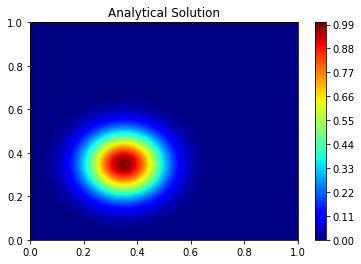

In [4]:

# Plot the exact solution
n_plot_vals = 50
x_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)
y_plot_vals_1D = np.linspace(0.0+1E-7, 1.0-1E-7, n_plot_vals)
x_plot_vals, y_plot_vals = np.meshgrid(x_plot_vals_1D, y_plot_vals_1D)

# Get the analytical solution
u_analytical_plot_vals = u_analytical(x_plot_vals, y_plot_vals)

plt.figure()
plt.contourf(x_plot_vals, y_plot_vals, u_analytical_plot_vals, 100, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.title("Analytical Solution")



In [5]:

du_exact_dx_sympy = sympy.diff(u_exact_sympy, x_sympy)
du_exact_dy_sympy = sympy.diff(u_exact_sympy, y_sympy)

d2u_exact_dx2_sympy = sympy.diff(du_exact_dx_sympy, x_sympy)
d2u_exact_dy2_sympy = sympy.diff(du_exact_dy_sympy, y_sympy)

# Lambdify the RHS:
f_rhs_analytical = sympy.lambdify((x_sympy, y_sympy), d2u_exact_dx2_sympy + d2u_exact_dy2_sympy)

### Mesh Setup

In [6]:
# Get the meshes

p = 1

mesh_files = [
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.15.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.1.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.075.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.05.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.04.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.035.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.03.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.025.msh",
    "mesh/Tri_Mesh_2D_UnitSquarePositive_CharLength0.0125.msh"
]

def dirichlet_bc_flag(x, y):
    if abs(x - 1.) < 1E-10 or abs(y - 1.) < 1E-10 or abs(x - 0.) < 1E-10 or abs(y - 0.) < 1E-10:
        return True, u_analytical(x,y)
    return False, None

mesh_properties = {
    "dirichlet_bc_flag": dirichlet_bc_flag
}


### Error Convergence Study

In [7]:

# Store tuples of [ndof, global L2 error]
error_convergence = []
error_convergence_Linf = []

for i in tnrange(5):

    mesh_obj = mesh.TriMeshGMSH(p, mesh_properties, mesh_files[i])
    
    # Create the Poisson Solver
    poisson_solver = solver.PoissonSolver(mesh_obj, f_rhs_analytical)

    # Assemble the LHS and RHS and solve the system
    poisson_solver.assemble_system()
    poisson_solver.solve_system()

    # L2 Error Computation
    global_L2_error = poisson_solver.compute_L2_error(u_analytical)
    error_convergence.append([len(mesh_obj.dof_list), global_L2_error])
    
    # Linf Errror Computation
    global_Linf_error = poisson_solver.compute_Linf_error(u_analytical)
    error_convergence_Linf.append([len(mesh_obj.dof_list), global_Linf_error])
    

### Post Processing

Text(0,0.5,'$L_2$ Error')

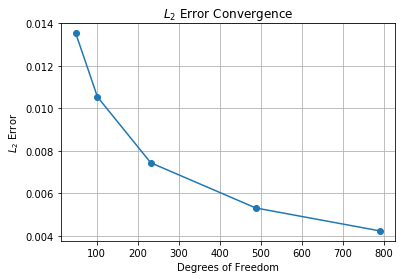

In [8]:

# Plot the L2 Error Convergence

ndof_vals = [x[0] for x in error_convergence]
l2_error_vals = [x[1] for x in error_convergence]

plt.plot(ndof_vals, l2_error_vals, marker="o")
plt.grid()

plt.title(r"$L_2$ Error Convergence")
plt.xlabel("Degrees of Freedom")
plt.ylabel(r"$L_2$ Error")


Text(0,0.5,'$L_2$ Error')

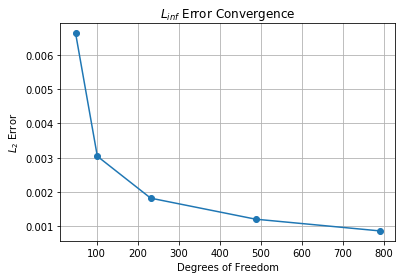

In [9]:
# Plot the Linf Error Convergence

ndof_vals = [x[0] for x in error_convergence_Linf]
linf_error_vals = [x[1] for x in error_convergence_Linf]

plt.plot(ndof_vals, linf_error_vals, marker="o")
plt.grid()

plt.title(r"$L_{inf}$ Error Convergence")
plt.xlabel("Degrees of Freedom")
plt.ylabel(r"$L_2$ Error")

In [10]:
output_file = "results/unadapted_exp_case_convergence_L2.txt"

with open(output_file, "w") as fp:
    for i in range(len(error_convergence)):
        fp.write("%.14e %.14e \n" % (ndof_vals[i], l2_error_vals[i]))
    

In [11]:
output_file = "results/unadapted_exp_case_convergence_Linf.txt"

with open(output_file, "w") as fp:
    for i in range(len(error_convergence)):
        fp.write("%.14e %.14e \n" % (ndof_vals[i], linf_error_vals[i]))